# ML Pipeline for the UNITI dataset

## Purpose of this notebook
- [x] Prepare dataframe for ML
- [x] Create baseline models
    - [x] User-based
        - [x] last known assessment *of this user*
        - [x] all known assessments *of this user*
    - [x] Assessment-based
        - [x] last known assessment
        - [x] all assessments
- [ ] Perform different split approaches to get different model solutions
    - [x] Answer-Cut
    - [x] Time-Cut
    - [ ] User-wise 
    - [x] Average-user
    - [ ] Group-wise
- [ ] Evalulate all approaches in one table in terms of performance and robustness

## Prepare dataframe for ML

In [1]:
# imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier

# to import own modules, a workaround - assuming the curent working directory is the folder (your/local/path/UsAs/src/d01_analysis
import sys
sys.path.insert(0, "../..")

from src.d00_utils import helpers

In [2]:
# suppress annoying warnings
pd.options.mode.chained_assignment = None

In [3]:
# read in df
df = pd.read_csv('../../data/d01_raw/uniti/uniti_dataset_22.09.28.csv')
df.index.names= ['answer_id']
df = helpers.create_target_shift(df, target_name='cumberness')

Define test data to evaluate all approaches on the same testset.

20 % of the users shall be taken for test, 80 % for trying out different approaches.

In [4]:
# define random state
random_state=1994

# define list of users
users_list = df.user_id.unique()
# 20 % into train users
test_users = pd.Series(users_list).sample(frac=0.2, random_state=random_state).to_list()
# 80 % into test users
train_users = [x for x in users_list if x not in set(test_users)]
# unit test 1
assert set(train_users + test_users) == set(users_list)

# get train and test dataframe
# use train to check approaches, use test to validate approaches
df_train = df[df['user_id'].isin(train_users)]
df_test = df[df['user_id'].isin(test_users)]

In [5]:
# define features and target
features = ['loudness', 'cumberness', 'jawbone', 'neck', 'tin_day', 'tin_cumber', 'tin_max', 'movement', 'stress', 'emotion']
target = 'cumberness_t1'

# set up for classification
bins = [-0.01, 20, 40, 60, 80, 100]
LE = LabelEncoder()

# preare dataset and model
model, X_train, X_test, y_train, y_test = helpers.prepare_and_instantiate(df_train, df_test, features, target, bins, LE, fit=True)

# Create mapping
_ = LE.fit_transform(y_train)
mapping = dict(zip(range(len(LE.classes_)), LE.classes_))

# cross validation setup
n_splits = 5
test_size = 1/n_splits

## Create baseline models

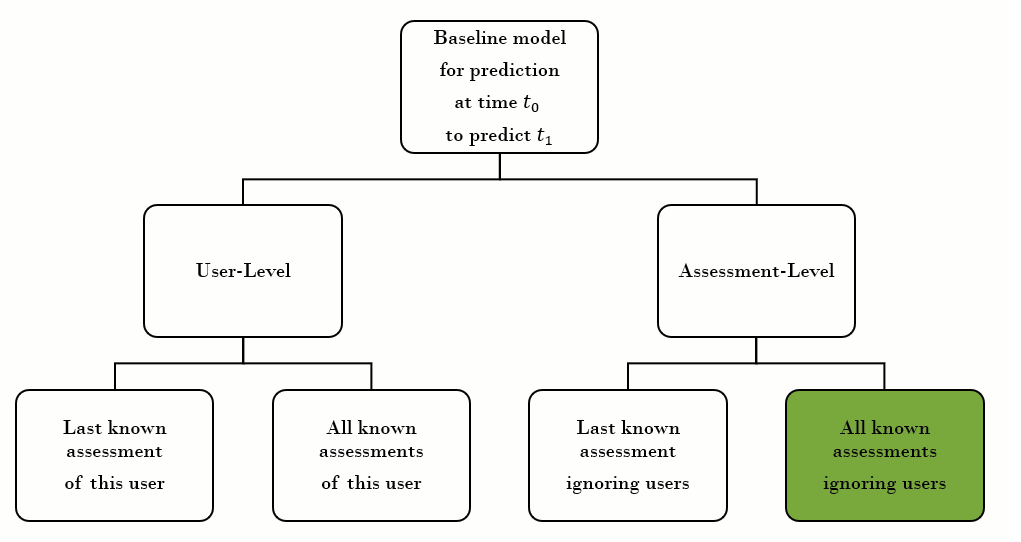

Performance within TRAIN
Assessment approach
f1_weighted mean 	 0.23802566237397552
standarddeviation 	 0.0019227548368315076
#################################################
User approach
f1_weighted mean 	 0.514010952812136
standarddeviation 	 0.004165404395612396
Performance within TEST
Final score assessment approach:	 0.22433844435262426


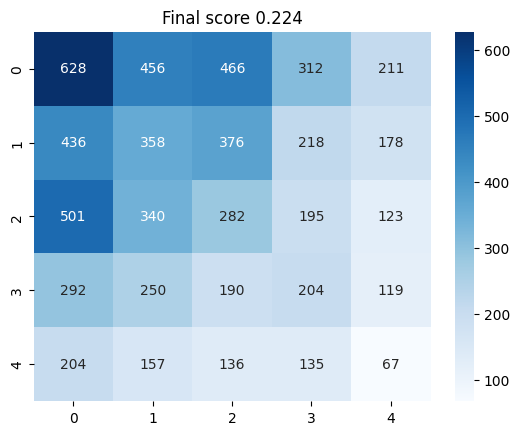

Final score user approach:	 0.5765862438239029


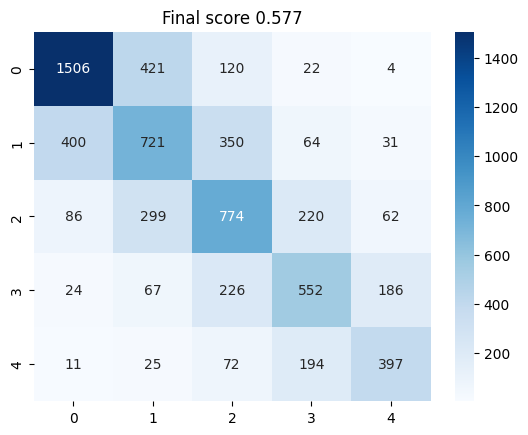

In [14]:
# instantiate model
model = helpers.baseline_model()

# define constants
target_name='cumberness'
approach='last'

# train model in cross validation
cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
scores_a = []
scores_u = []
for _, val_indices in cv.split(df_train):
    
    # divide all train data into folds
    df_train_val_fold = df_train.iloc[val_indices, :]
    
    # get baseline prediction
    y_pred_a = model.get_baseline_assessment_prediction(data=df_train_val_fold, target_name=target_name, approach=approach, time_col = 'created_at')
    y_pred_u = model.get_baseline_user_prediction(data=df_train_val_fold, target_name=target_name, approach=approach, time_col = 'created_at')
    y_true = df_train_val_fold[target]
    
    assert y_pred_a.shape[0] == y_true.shape[0]
    
    # map into classes
    y_pred_a = pd.cut(y_pred_a, bins=bins)
    y_pred_u = pd.cut(y_pred_u, bins=bins)
    y_true = pd.cut(y_true, bins=bins)
    
    # encode to labels
    y_true = LE.fit_transform(y_true)
    y_pred_u = LE.transform(y_pred_u)
    y_pred_a = LE.transform(y_pred_a)
    
    # calculate score
    f1_score_test_a = f1_score(y_true, y_pred_a, average='weighted')
    f1_score_test_u = f1_score(y_true, y_pred_u, average='weighted')
    scores_a.append(f1_score_test_a)
    scores_u.append(f1_score_test_u)
    
# validate model
print('Performance within TRAIN')
print('Assessment approach')
print('f1_weighted mean \t', np.array(scores_a).mean())
print('standarddeviation \t', np.array(scores_a).std())
print('#################################################')
print('User approach')
print('f1_weighted mean \t', np.array(scores_u).mean())
print('standarddeviation \t', np.array(scores_u).std())
# evaluate on test set

# assessment------------------------------------------------------------------------------
y_pred_a = model.get_baseline_assessment_prediction(data=df_test, target_name=target_name, approach=approach).values
# map into classes
y_pred_a = pd.cut(pd.Series(y_pred_a), bins=bins)
# encode to labels
y_pred_a = LE.transform(y_pred_a)

f1_score_test_a = f1_score(y_test, y_pred_a, average='weighted')
final_score_a = f1_score_test_a - 0.5 * np.array(scores_a).std()

print('Performance within TEST')
print('Final score assessment approach:\t', final_score_a)



# visualize confusion matrix
# assessment
helpers.visualize_confusion_matrix(y_test, y_pred_a, mapping, final_score_a)

# user------------------------------------------------------------------------------------

y_pred_u = model.get_baseline_user_prediction(data=df_test, target_name=target_name, approach=approach).values
# map into classes
y_pred_u = pd.cut(pd.Series(y_pred_u), bins=bins)
# encode to labels
y_pred_u = LE.transform(y_pred_u)
f1_score_test_u = f1_score(y_test, y_pred_u, average='weighted')
final_score_u = f1_score_test_u - 0.5 * np.array(scores_u).std()

print('Final score user approach:\t', final_score_u)

helpers.visualize_confusion_matrix(y_test, y_pred_u, mapping, final_score_u)

### Take last assessment

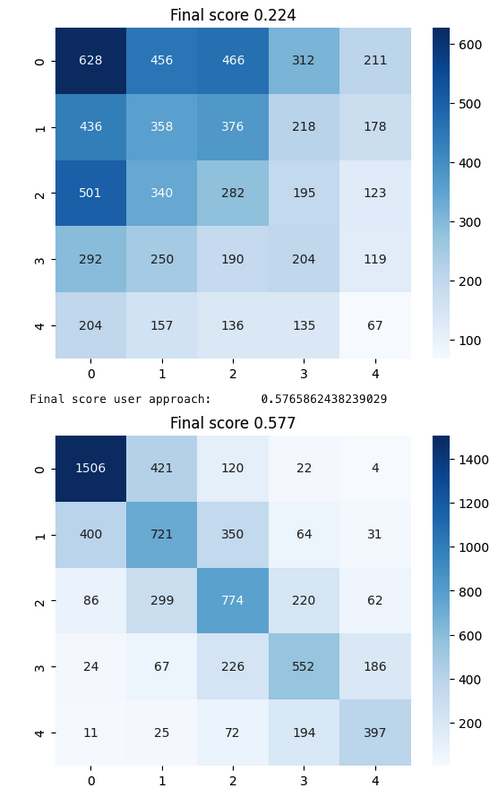

### Take all known assessments

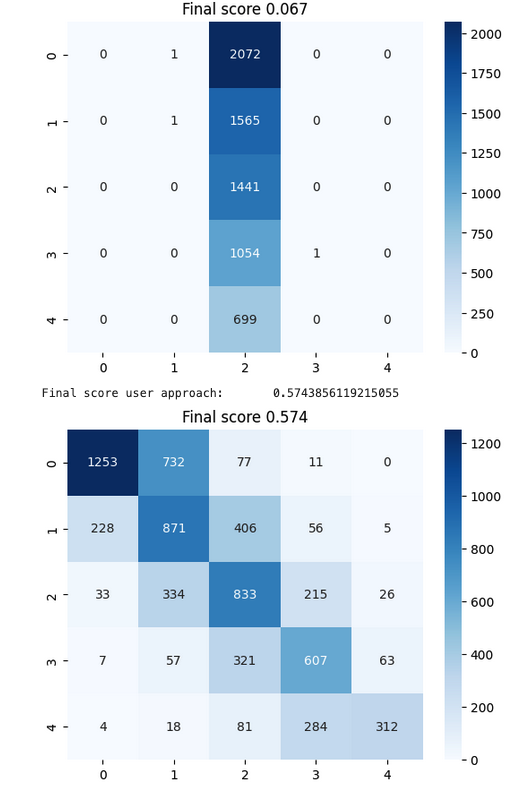

#### Assessment approach
 - `last`: The confusion matrix looks like the model reproduces the distribution of the target of the testset. The performance is worst here.
 - `all`: The more data the model knows, the more it estimates the average class which finally leads to a model only predicts the average class.
 
#### User approach
 - `last`: It looks like the users have a low variance in their reporting behavior. The last known value of this user is the best guess here with almost perfect performance.
 - `all`: This approach is ranked 2nd. Since some user vary their answers during the study, the approach sometimes fails.

## Perform different split approaches to get different model solutions

### Approach | Assessment | Answer-cut

Performance within train
f1_weighted mean  0.5733253208463538
standarddeviation  0.004079341959798972
f1_weighted testscore:  0.592


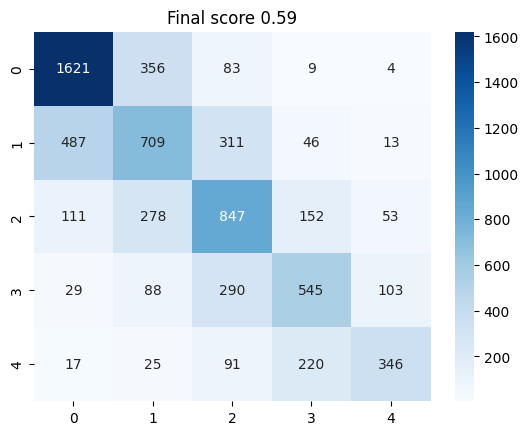

In [8]:
# instantiate model
model = RandomForestClassifier(random_state=random_state)

# train model
cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_weighted')

# validate model
print('Performance within train')
print('f1_weighted mean ', scores.mean())
print('standarddeviation ', scores.std())

y_pred, f1_final = helpers.fit_and_calc_score(model, X_train, X_test, y_train, y_test, scores)

# visualize confusion matrix
helpers.visualize_confusion_matrix(y_test, y_pred, mapping, f1_final)

With the standard random shuffle and ignoring user aspects, the model is better than random guessing. However, without having the information that user groups exist, the score is well below 60 %.

### Approach | Assessment | Time-cut

Performance within train
f1_weighted mean  0.58
standarddeviation  0.002
f1_weighted testscore:  0.571


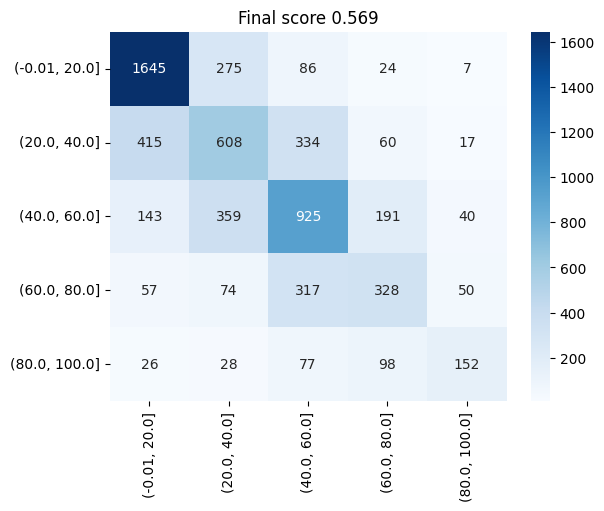

In [8]:
# 80 % of first data into train, 20 % into test
row80 = int(df.shape[0]*0.8)
df_train = df.iloc[:row80, :]
df_test = df.iloc[row80:, :]

model, X_train, X_test, y_train, y_test = helpers.prepare_and_instantiate(df_train, df_test, features, target, bins, LE)

# create a group column. Each group belongs to a dategroup. The first 20% of the train data belong to date_group_1, the next 20% belong to date_group_2, and so on.
groups = np.sort(np.random.randint(low=1, high=5+1, size = df_train.shape[0]))

# train model
cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_weighted', groups=groups)

# validate model
print('Performance within train')
print('f1_weighted mean ', round(scores.mean(), 3))
print('standarddeviation ', round(scores.std(), 3))

y_pred, f1_final = helpers.fit_and_calc_score(model, X_train, X_test, y_train, y_test, scores)

# visualize confusion matrix
helpers.visualize_confusion_matrix(y_test, y_pred, mapping, f1_final)

Making a precise differentiation with evenly sized time chunks, the model improves to the random approach. This might be due to the fact that some users joined the study later, so there was an indirect grouped kfold validation. The score improves from the random approach by 3%-points.

### Approach | User | Average-user

For each assesment, check the user id and calculate the mean of all answers known by this user so far. These mean replace the reported assessments.

Performance within train
f1_weighted mean  0.5938375499629118
standarddeviation  0.00796283134079024
f1_weighted testscore:  0.504


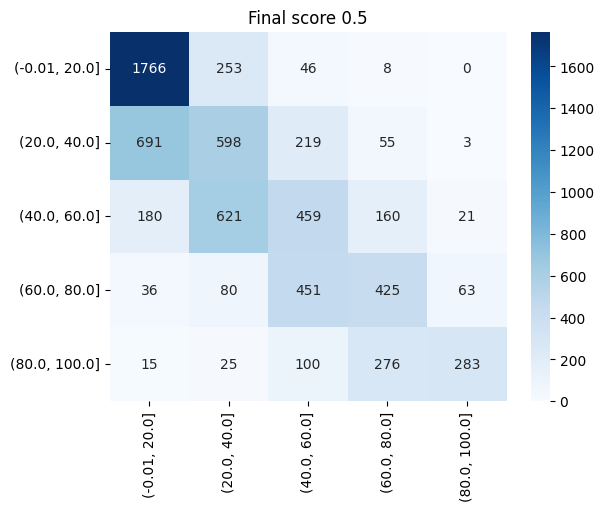

In [12]:
# get original train and test users
df_train = df[df['user_id'].isin(train_users)]
df_test = df[df['user_id'].isin(test_users)]

# create a group column. Each group belongs to a dategroup. The first 20% of the train data belong to date_group_1, the next 20% belong to date_group_2, and so on.
groups = np.sort(np.random.randint(low=1, high=5+1, size = df_train.shape[0]))

# calculate grouped cumulative means for all assessments of all users
df_train_avg_user = helpers.calc_cum_mean(df_train, features, user_id='user_id')
df_test_avg_user = helpers.calc_cum_mean(df_test, features, user_id='user_id')

# prepare data and model
model, X_train, X_test, y_train, y_test = helpers.prepare_and_instantiate(df_train_avg_user, df_test_avg_user, features, target, bins, LE)

# train model
cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_weighted', groups=groups)

# validate model
print('Performance within train')
print('f1_weighted mean ', scores.mean())
print('standarddeviation ', scores.std())

# fit and calculate
y_pred, f1_final = helpers.fit_and_calc_score(model, X_train, X_test, y_train, y_test, scores)

# visualize confusion matrix
helpers.visualize_confusion_matrix(y_test, y_pred, mapping, f1_final)

The model overfits on the users from the train set. The drop from train to test is 9%-points. The between-fold variance is low with less than 1%.
The answer behavior of users from the train set differs to those from the test set - that could be a reason for the high performance drop.

## Evalulate all approaches in one table in terms of performance and robustness